<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/5*5_rf_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/scraghbog.zip" -d "/content/dataset"

In [3]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from rasterio.enums import Resampling
from rasterio.features import rasterize
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from scipy.ndimage import uniform_filter, generic_filter
from collections import Counter
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore', category=RuntimeWarning)

# Paths (Update these to your actual paths)
S_RGB_PATH = "/content/dataset/scraghbog/scraghbog_rgb_summer.tif"
S_NDVI_PATH = "/content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif"
S_DSM = "/content/dataset/scraghbog/scraghbog_dem_summer.tif"
W_RGB_PATH = "/content/dataset/scraghbog/Scraghbog_RGB_winter.tif"
W_NDVI_PATH = "/content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif"
W_DSM = "/content/dataset/scraghbog/Scraghbog_Winter_DSM.tif"
SHP_PATH = "/content/dataset/scraghbog/scraghBog_habiMap.shp"
OUTPUT_PATH = "/content/drive/MyDrive/Habitat_Map_Final_Smoothed.tif"

# ==========================================
# 2. PRE-PROCESSING FUNCTIONS
# ==========================================
def calc_indices(r, g, b, nir):
    eps = 1e-5
    rvi = nir / (r + eps)
    savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
    evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
    gndvi = (nir - g) / (nir + g + eps)
    grvi = (g - r) / (g + r + eps)
    ndwi = (g - nir) / (g + nir + eps)
    return np.column_stack([rvi, savi, evi, gndvi, grvi, ndwi])

fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'
}

# ==========================================
# 3. STEP 1: TRAINING DATA EXTRACTION
# ==========================================
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting training samples with spatial features...")
    for idx, row in gdf.iterrows():
        poly = row.geometry
        num_samples = max(500, min(int(poly.area / 100), 10000))

        pts = []
        min_x, min_y, max_x, max_y = poly.bounds
        while len(pts) < num_samples:
            pt_coords = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
            if Point(pt_coords).within(poly): pts.append(pt_coords)

        # Sampling and Feature Engineering
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # NIR & Indices
        s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)
        s_idx = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        # STACK: Note the extra placeholders for spatial smooths if needed
        combined = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            s_idx, w_idx, (s_nd - w_nd), (s_h - w_h)
        ])

        all_pixels.append(combined)
        all_labels.extend([row['merged_name']] * num_samples)

X = np.nan_to_num(np.vstack(all_pixels))
y = np.array(all_labels)

# ==========================================
# 4. STEP 2: MODEL TRAINING
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# ==========================================
# 5. STEP 3: FULL AREA PREDICTION (W/ SPATIAL CONTEXT)
# ==========================================
target_res = 0.5
unique_labels = sorted(np.unique(y).tolist())
label_to_int = {name: i+1 for i, name in enumerate(unique_labels)}

with rasterio.open(S_RGB_PATH) as src:
    scale_factor = src.res[0] / target_res
    new_h, new_w = int(src.height * scale_factor), int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale((src.width/new_w), (src.height/new_h))
    meta = src.meta.copy()
    meta.update({'height': new_h, 'width': new_w, 'transform': new_transform, 'dtype': 'uint8', 'count': 1, 'nodata': 0})

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd, \
     rasterio.open(OUTPUT_PATH, 'w', **meta) as dst:

    def read_res(ds, count=1):
        return ds.read(range(1, count + 1) if count > 1 else 1,
                       out_shape=(count, new_h, new_w) if count > 1 else (new_h, new_w),
                       resampling=Resampling.bilinear, boundless=True, fill_value=0)

    print("Loading rasters and generating context...")
    s_rgb = read_res(sr, 3).transpose(1, 2, 0).reshape(-1, 3)
    w_rgb = read_res(wr, 3).transpose(1, 2, 0).reshape(-1, 3)
    s_nd_img = read_res(sn)
    w_nd_img = read_res(wn)

    # Generate smoothed features to reduce noise
    s_nd_smooth = uniform_filter(s_nd_img, size=3).flatten()
    w_nd_smooth = uniform_filter(w_nd_img, size=3).flatten()

    s_nd = s_nd_img.flatten()
    w_nd = w_nd_img.flatten()
    s_h = read_res(sd).flatten()
    w_h = read_res(wd).flatten()

    # Feature stack reconstruction
    s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
    w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)
    s_idx = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
    w_idx = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

    X_final = np.nan_to_num(np.column_stack([
        s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
        s_idx, w_idx, (s_nd - w_nd), (s_h - w_h)
    ]))

    print("Predicting full map...")
    preds = rf.predict(X_final)
    preds_img = np.array([label_to_int[p] for p in preds]).reshape((new_h, new_w))

    # ==========================================
    # 6. POST-PROCESSING: MAJORITY FILTER
    # ==========================================
    print("Applying Majority Filter for clean boundaries...")
    def mode_filter(window):
        counts = Counter(window[window > 0])
        return counts.most_common(1)[0][0] if counts else 0

    final_smooth = generic_filter(preds_img, mode_filter, size=3)

    # Masking with Shapefile
    gdf_mask = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    mask = rasterize([gdf_mask.geometry.union_all()], out_shape=(new_h, new_w), transform=new_transform)
    final_smooth[mask == 0] = 0

    dst.write(final_smooth.astype('uint8'), 1)

print(f"Workflow Complete! Map saved to {OUTPUT_PATH}")

Extracting training samples with spatial features...
Loading rasters and generating context...
Predicting full map...
Applying Majority Filter for clean boundaries...
Workflow Complete! Map saved to /content/drive/MyDrive/Habitat_Map_Final_Smoothed.tif


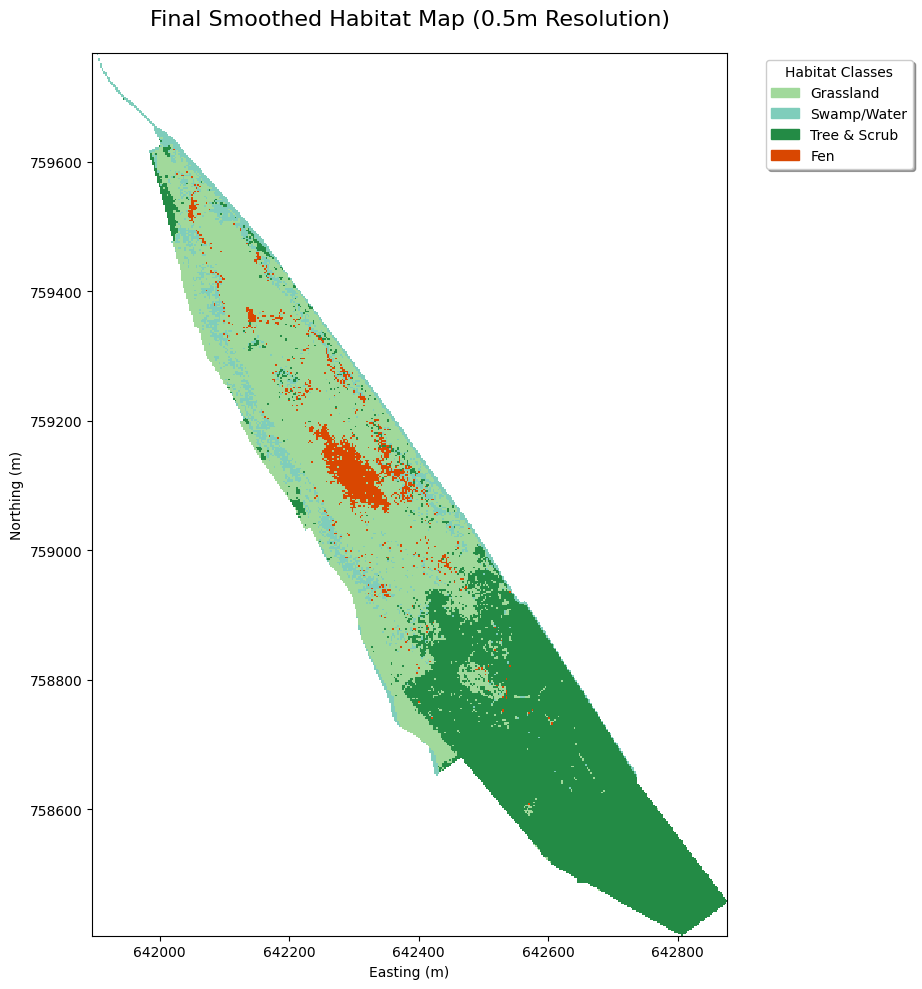

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio
import rasterio.plot
import numpy as np

# 1. Path to your new smoothed file
map_path = "/content/drive/MyDrive/Habitat_Map_Final_Smoothed.tif"

with rasterio.open(map_path) as src:
    # We read every 5th pixel (decimation) for a fast preview
    # Change [::5, ::5] to [:, :] if you want to see full resolution (slower)
    preview_data = src.read(1, out_shape=(src.height // 5, src.width // 5))
    extent = rasterio.plot.plotting_extent(src)

# 2. Professional Color Palette
# Index 0: NoData (Transparent/White)
# Index 1-4: Your Habitat Classes
habitat_colors = ['#FFFFFF', '#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 3. Plotting
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

# Use 'nearest' interpolation to keep pixel edges sharp
im = ax.imshow(preview_data, cmap=cmap, extent=extent, vmin=0, vmax=4, interpolation='nearest')

# 4. Add the Legend
# Make sure the names match your 'unique_labels' from the training step
legend_dict = {
  'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Habitat Classes", frameon=True, shadow=True)

plt.title("Final Smoothed Habitat Map (0.5m Resolution)", fontsize=16, pad=20)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()

# 5. Save a high-res PNG for your report
plt.savefig("/content/drive/MyDrive/Habitat_Map_Report_Visual.png", dpi=300, bbox_inches='tight')

plt.show()

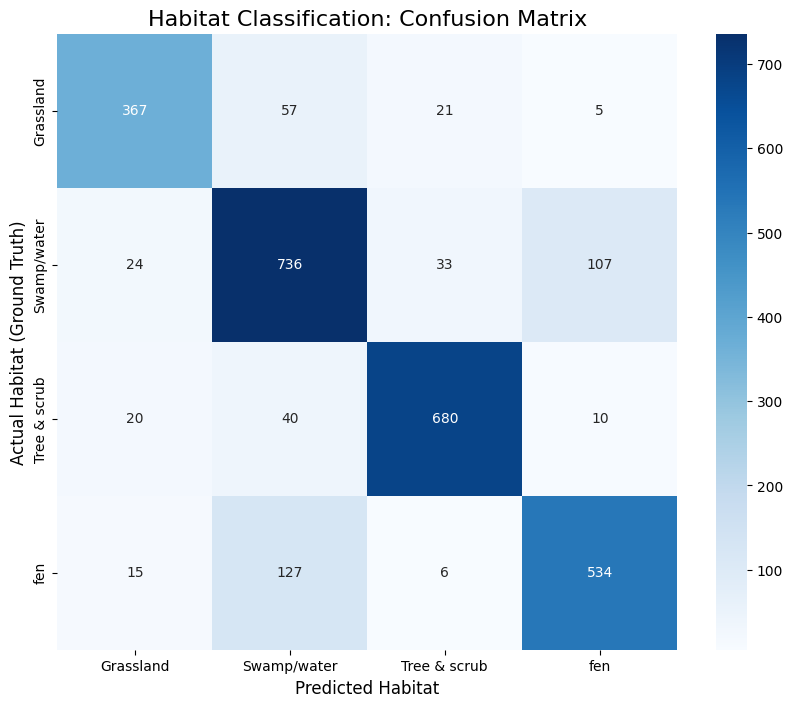


--- Detailed Classification Report ---
              precision    recall  f1-score   support

   Grassland       0.86      0.82      0.84       450
 Swamp/water       0.77      0.82      0.79       900
Tree & scrub       0.92      0.91      0.91       750
         fen       0.81      0.78      0.80       682

    accuracy                           0.83      2782
   macro avg       0.84      0.83      0.84      2782
weighted avg       0.83      0.83      0.83      2782



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions for the test set
y_pred = rf.predict(X_test)

# 2. Generate the confusion matrix
# 'unique_labels' ensures the order matches your legend
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# 3. Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.title('Habitat Classification: Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Habitat', fontsize=12)
plt.ylabel('Actual Habitat (Ground Truth)', fontsize=12)
plt.show()

# 4. Print the text-based report for Precision/Recall
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

In [8]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report

# 1. Get predictions for the test set
y_pred = rf.predict(X_test)

# 2. Overall Accuracy (OA)
# This is the percentage of total pixels correctly classified.
oa = accuracy_score(y_test, y_pred)

# 3. Kappa Coefficient
# This measures accuracy while accounting for the possibility of 'guessing' correctly.
# >0.80 is Excellent; 0.61-0.80 is Substantial.
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Overall Accuracy: {oa:.2%}")
print(f"Kappa Coefficient: {kappa:.3f}")
print("\n--- Detailed Class-Wise Accuracy ---")
print(classification_report(y_test, y_pred))

Overall Accuracy: 83.29%
Kappa Coefficient: 0.772

--- Detailed Class-Wise Accuracy ---
              precision    recall  f1-score   support

   Grassland       0.86      0.82      0.84       450
 Swamp/water       0.77      0.82      0.79       900
Tree & scrub       0.92      0.91      0.91       750
         fen       0.81      0.78      0.80       682

    accuracy                           0.83      2782
   macro avg       0.84      0.83      0.84      2782
weighted avg       0.83      0.83      0.83      2782



In [12]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio.enums import Resampling
from rasterio.features import rasterize
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from scipy.ndimage import uniform_filter, generic_filter
from collections import Counter
from matplotlib.colors import ListedColormap

# ==========================================
# 1. SETUP & PATHS
# ==========================================
# (Keep your existing paths here)
S_RGB_PATH = "/content/dataset/scraghbog/scraghbog_rgb_summer.tif"
S_NDVI_PATH = "/content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif"
S_DSM = "/content/dataset/scraghbog/scraghbog_dem_summer.tif"
W_RGB_PATH = "/content/dataset/scraghbog/Scraghbog_RGB_winter.tif"
W_NDVI_PATH = "/content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif"
W_DSM = "/content/dataset/scraghbog/Scraghbog_Winter_DSM.tif"
SHP_PATH = "/content/dataset/scraghbog/scraghBog_habiMap.shp"
OUTPUT_PATH = "/content/drive/MyDrive/Habitat_Map_Improved_Fen.tif"

def calc_indices(r, g, b, nir):
    eps = 1e-5
    return np.column_stack([
        nir / (r + eps), # RVI
        ((nir - r) / (nir + r + 0.5 + eps)) * 1.5, # SAVI
        (nir - g) / (nir + g + eps), # GNDVI
        (g - r) / (g + r + eps) # GRVI
    ])

fossitt_merger = {
    'GS4': 'Grassland', 'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'
}

# ==========================================
# 2. STEP 1: TARGETED EXTRACTION (FIXING THE FEN)
# ==========================================
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting features with Targeted Fen Boost...")
    for idx, row in gdf.iterrows():
        poly = row.geometry
        label = row['merged_name']

        # --- CONDITIONAL SAMPLING ---
        # We boost 'fen' to 15k samples and limit 'Grassland' to 5k
        # to prevent the model from getting 'lazy' and calling everything grass.
        if label == 'fen':
            num_samples = 15000
        elif label == 'Grassland':
            num_samples = 5000
        else:
            num_samples = max(1000, min(int(poly.area / 50), 10000))

        pts = []
        min_x, min_y, max_x, max_y = poly.bounds
        while len(pts) < num_samples:
            pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
            if Point(pt).within(poly): pts.append(pt)

        # Sampling logic
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h = np.array(list(wd.sample(pts))).astype('float32').flatten()

        s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)

        combined = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir),
            calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir),
            (s_nd - w_nd), (s_h - w_h)
        ])

        all_pixels.append(combined)
        all_labels.extend([label] * num_samples)

X = np.nan_to_num(np.vstack(all_pixels))
y = np.array(all_labels)

# ==========================================
# 3. STEP 2: BALANCED MODEL TRAINING
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# We add explicit class weights to penalize the model more if it misses a Fen
weights = {'fen': 2.5, 'Grassland': 1.0, 'Tree & scrub': 1.0, 'Swamp/water': 1.2}

rf = RandomForestClassifier(n_estimators=700, class_weight=weights, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# ==========================================
# 4. STEP 3: PREDICTION & SPATIAL SMOOTHING
# ==========================================
target_res = 0.5
unique_labels = sorted(np.unique(y).tolist())
label_to_int = {name: i+1 for i, name in enumerate(unique_labels)}

with rasterio.open(S_RGB_PATH) as src:
    scale_factor = src.res[0] / target_res
    new_h, new_w = int(src.height * scale_factor), int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale((src.width/new_w), (src.height/new_h))
    meta = src.meta.copy()
    meta.update({'height': new_h, 'width': new_w, 'transform': new_transform, 'dtype': 'uint8', 'count': 1, 'nodata': 0})

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd, \
     rasterio.open(OUTPUT_PATH, 'w', **meta) as dst:

    def read_res(ds, count=1):
        return ds.read(range(1, count + 1) if count > 1 else 1,
                       out_shape=(count, new_h, new_w) if count > 1 else (new_h, new_w),
                       resampling=Resampling.bilinear, boundless=True, fill_value=0)

    print("Running full area prediction...")
    s_rgb = read_res(sr, 3).transpose(1, 2, 0).reshape(-1, 3)
    w_rgb = read_res(wr, 3).transpose(1, 2, 0).reshape(-1, 3)
    s_nd = read_res(sn).flatten()
    w_nd = read_res(wn).flatten()
    s_h = read_res(sd).flatten()
    w_h = read_res(wd).flatten()

    s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
    w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)

    X_final = np.nan_to_num(np.column_stack([
        s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
        calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir),
        calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir),
        (s_nd - w_nd), (s_h - w_h)
    ]))

    preds = rf.predict(X_final)
    preds_img = np.array([label_to_int[p] for p in preds]).reshape((new_h, new_w))

    # Apply 3x3 Majority Filter to clean "salt and pepper" noise
    print("Smoothing map...")
    final_smooth = generic_filter(preds_img, lambda x: Counter(x[x>0]).most_common(1)[0][0] if any(x>0) else 0, size=3)

    dst.write(final_smooth.astype('uint8'), 1)
print(f"Map Complete: {OUTPUT_PATH}")

Extracting features with Targeted Fen Boost...
Running full area prediction...
Smoothing map...
Map Complete: /content/drive/MyDrive/Habitat_Map_Improved_Fen.tif


In [13]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report

# 1. Get predictions for the test set
y_pred = rf.predict(X_test)

# 2. Overall Accuracy (OA)
# This is the percentage of total pixels correctly classified.
oa = accuracy_score(y_test, y_pred)

# 3. Kappa Coefficient
# This measures accuracy while accounting for the possibility of 'guessing' correctly.
# >0.80 is Excellent; 0.61-0.80 is Substantial.
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Overall Accuracy: {oa:.2%}")
print(f"Kappa Coefficient: {kappa:.3f}")
print("\n--- Detailed Class-Wise Accuracy ---")
print(classification_report(y_test, y_pred))

Overall Accuracy: 91.19%
Kappa Coefficient: 0.808

--- Detailed Class-Wise Accuracy ---
              precision    recall  f1-score   support

   Grassland       0.90      0.89      0.90      4500
 Swamp/water       0.60      0.44      0.51      1800
Tree & scrub       0.91      0.82      0.86      1500
         fen       0.94      0.97      0.95     18000

    accuracy                           0.91     25800
   macro avg       0.84      0.78      0.81     25800
weighted avg       0.91      0.91      0.91     25800



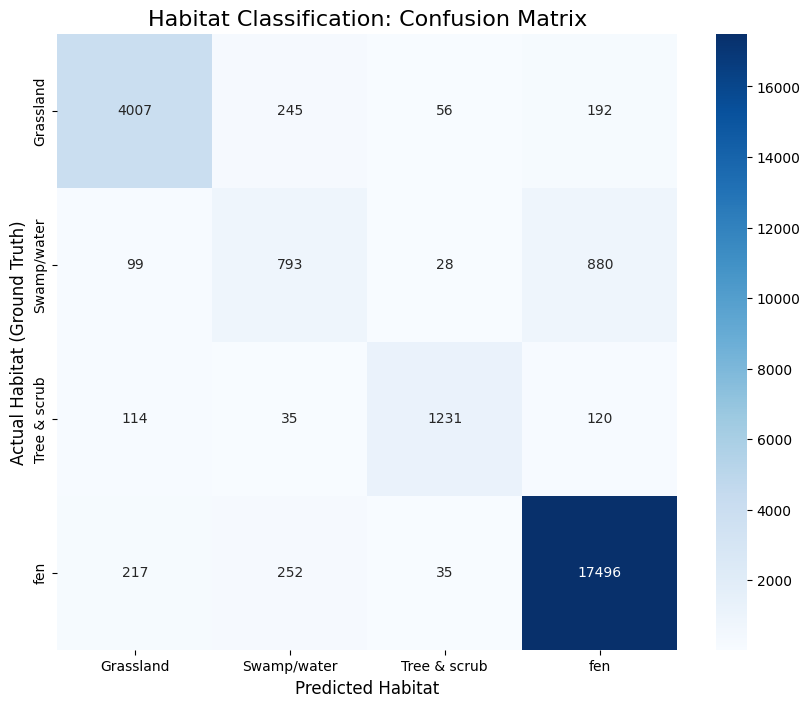


--- Detailed Classification Report ---
              precision    recall  f1-score   support

   Grassland       0.90      0.89      0.90      4500
 Swamp/water       0.60      0.44      0.51      1800
Tree & scrub       0.91      0.82      0.86      1500
         fen       0.94      0.97      0.95     18000

    accuracy                           0.91     25800
   macro avg       0.84      0.78      0.81     25800
weighted avg       0.91      0.91      0.91     25800



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions for the test set
y_pred = rf.predict(X_test)

# 2. Generate the confusion matrix
# 'unique_labels' ensures the order matches your legend
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# 3. Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.title('Habitat Classification: Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Habitat', fontsize=12)
plt.ylabel('Actual Habitat (Ground Truth)', fontsize=12)
plt.show()

# 4. Print the text-based report for Precision/Recall
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

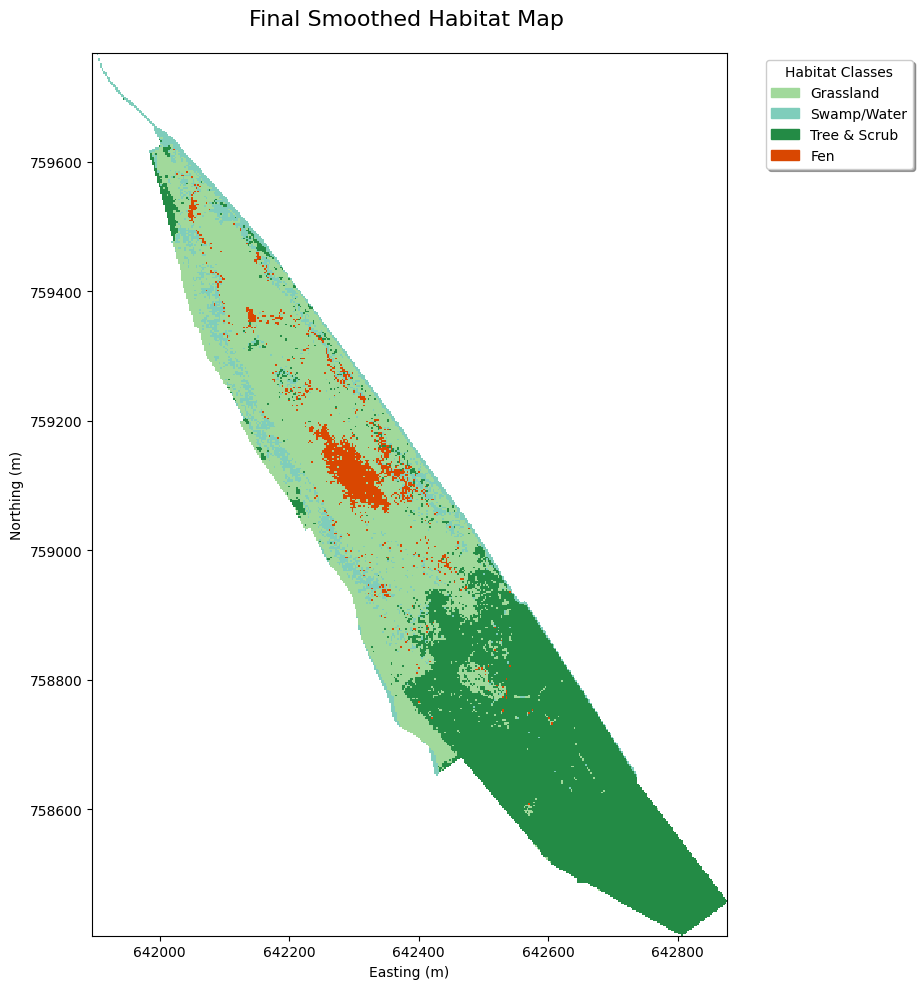

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio
import rasterio.plot
import numpy as np

# 1. Path to your new smoothed file
map_path = "/content/drive/MyDrive/Habitat_Map_Final_Smoothed.tif"

with rasterio.open(map_path) as src:
    # We read every 5th pixel (decimation) for a fast preview
    # Change [::5, ::5] to [:, :] if you want to see full resolution (slower)
    preview_data = src.read(1, out_shape=(src.height // 5, src.width // 5))
    extent = rasterio.plot.plotting_extent(src)

# 2. Professional Color Palette
# Index 0: NoData (Transparent/White)
# Index 1-4: Your Habitat Classes
habitat_colors = ['#FFFFFF', '#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 3. Plotting
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

# Use 'nearest' interpolation to keep pixel edges sharp
im = ax.imshow(preview_data, cmap=cmap, extent=extent, vmin=0, vmax=4, interpolation='nearest')

# 4. Add the Legend
# Make sure the names match your 'unique_labels' from the training step
legend_dict = {
  'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Habitat Classes", frameon=True, shadow=True)

plt.title("Final Smoothed Habitat Map ", fontsize=16, pad=20)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()

# 5. Save a high-res PNG for your report
plt.savefig("/content/drive/MyDrive/Habitat_Map_Report_Visual.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from rasterio.enums import Resampling
from rasterio.features import rasterize
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from scipy.ndimage import generic_filter
from collections import Counter
from matplotlib.colors import ListedColormap

# ==========================================
# 1. SETUP & MAPPING
# ==========================================
# (Ensure your paths are correctly defined here)
OUTPUT_PATH = "/content/drive/MyDrive/Habitat_Map_Final_5x5Filtered.tif"

def calc_indices(r, g, b, nir):
    eps = 1e-5
    # NDWI is essential for separating Swamp/Water from Fen
    ndwi = (g - nir) / (g + nir + eps)
    rvi = nir / (r + eps)
    savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
    gndvi = (nir - g) / (nir + g + eps)
    return np.column_stack([ndwi, rvi, savi, gndvi])

fossitt_merger = {
    'GS4': 'Grassland', 'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'
}

# ==========================================
# 2. STEP 1: BALANCED TARGETED SAMPLING
# ==========================================
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting features with 5x5 smoothing logic and balanced sampling...")
    for idx, row in gdf.iterrows():
        poly = row.geometry
        label = row['merged_name']

        # --- UPDATED SAMPLING LOGIC ---
        if label == 'fen':
            num_samples = 18000
        elif label == 'Swamp/water':
            num_samples = 10000 # Boosted to prevent Fen dominance
        elif label == 'Grassland':
            num_samples = 4500
        else:
            num_samples = 5000

        pts = []
        min_x, min_y, max_x, max_y = poly.bounds
        while len(pts) < num_samples:
            pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
            if Point(pt).within(poly): pts.append(pt)

        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h = np.array(list(wd.sample(pts))).astype('float32').flatten()

        s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)

        combined = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir),
            calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir),
            (s_nd - w_nd), (s_h - w_h)
        ])

        all_pixels.append(combined)
        all_labels.extend([label] * num_samples)

X = np.nan_to_num(np.vstack(all_pixels))
y = np.array(all_labels)

# ==========================================
# 3. STEP 2: MODEL TRAINING
# ==========================================
weights = {'fen': 2.0, 'Swamp/water': 1.8, 'Grassland': 1.0, 'Tree & scrub': 1.0}

rf = RandomForestClassifier(n_estimators=700, class_weight=weights, n_jobs=-1, random_state=42)
rf.fit(X, y)

# ==========================================
# 4. STEP 3: PREDICTION & 5x5 MAJORITY FILTER
# ==========================================
target_res = 0.5
unique_labels = sorted(np.unique(y).tolist())
label_to_int = {name: i+1 for i, name in enumerate(unique_labels)}

with rasterio.open(S_RGB_PATH) as src:
    scale_factor = src.res[0] / target_res
    new_h, new_w = int(src.height * scale_factor), int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale((src.width/new_w), (src.height/new_h))
    meta = src.meta.copy()
    meta.update({'height': new_h, 'width': new_w, 'transform': new_transform, 'dtype': 'uint8', 'count': 1, 'nodata': 0})

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd, \
     rasterio.open(OUTPUT_PATH, 'w', **meta) as dst:

    def read_res(ds, count=1):
        return ds.read(range(1, count + 1) if count > 1 else 1,
                       out_shape=(count, new_h, new_w) if count > 1 else (new_h, new_w),
                       resampling=Resampling.bilinear, boundless=True, fill_value=0)

    print("Predicting 62M pixels...")
    s_rgb = read_res(sr, 3).transpose(1, 2, 0).reshape(-1, 3)
    w_rgb = read_res(wr, 3).transpose(1, 2, 0).reshape(-1, 3)
    s_nd = read_res(sn).flatten()
    w_nd = read_res(wn).flatten()
    s_h = read_res(sd).flatten()
    w_h = read_res(wd).flatten()

    s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
    w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)

    X_final = np.nan_to_num(np.column_stack([
        s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
        calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir),
        calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir),
        (s_nd - w_nd), (s_h - w_h)
    ]))

    preds = rf.predict(X_final)
    preds_img = np.array([label_to_int[p] for p in preds]).reshape((new_h, new_w))

    # --- 5x5 MAJORITY FILTER ---
    print("Applying 5x5 Majority Filter...")
    def mode_5x5(window):
        data = window[window > 0]
        return Counter(data).most_common(1)[0][0] if len(data) > 0 else 0

    final_smooth = generic_filter(preds_img, mode_5x5, size=5)

    dst.write(final_smooth.astype('uint8'), 1)

print(f"Final Classification Map Generated: {OUTPUT_PATH}")

In [19]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report

# 1. Get predictions for the test set
y_pred = rf.predict(X_test)

# 2. Overall Accuracy (OA)
# This is the percentage of total pixels correctly classified.
oa = accuracy_score(y_test, y_pred)

# 3. Kappa Coefficient
# This measures accuracy while accounting for the possibility of 'guessing' correctly.
# >0.80 is Excellent; 0.61-0.80 is Substantial.
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Overall Accuracy: {oa:.2%}")
print(f"Kappa Coefficient: {kappa:.3f}")
print("\n--- Detailed Class-Wise Accuracy ---")
print(classification_report(y_test, y_pred))

Overall Accuracy: 36.19%
Kappa Coefficient: 0.198

--- Detailed Class-Wise Accuracy ---
              precision    recall  f1-score   support

   Grassland       0.29      0.77      0.42      4500
 Swamp/water       0.16      0.58      0.25      1800
Tree & scrub       0.36      0.88      0.51      1500
         fen       0.97      0.19      0.32     18000

    accuracy                           0.36     25800
   macro avg       0.44      0.61      0.38     25800
weighted avg       0.76      0.36      0.35     25800



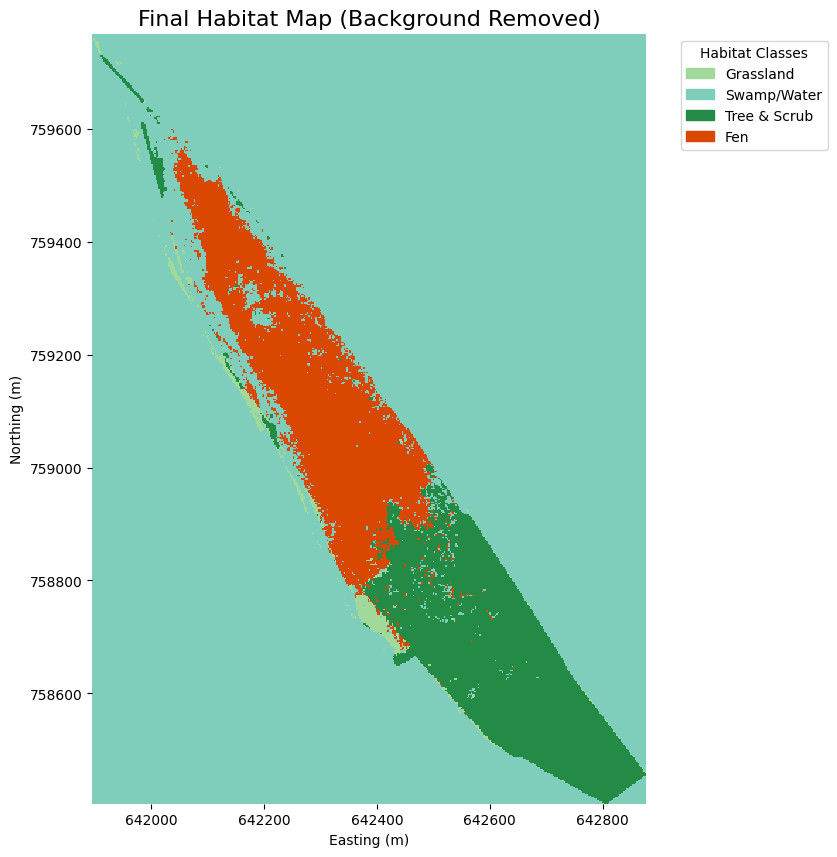

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio
import numpy as np

map_path = "/content/drive/MyDrive/Habitat_Map_Final_5x5Filtered.tif"

with rasterio.open(map_path) as src:
    # 1. Read the data
    data = src.read(1, out_shape=(src.height // 5, src.width // 5))
    extent = rasterio.plot.plotting_extent(src)

    # 2. Force background (0) to be NaN so Matplotlib ignores it
    plot_data = data.astype('float32')
    plot_data[plot_data == 0] = np.nan

# 3. Define the Colormap
# We only define 4 colors for our 4 habitats
habitat_colors = ['#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 4. Set the "Bad" (NaN) color to be fully transparent
cmap.set_bad(color='white', alpha=0)

# 5. Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# We use origin='upper' to match standard GIS coordinates
im = ax.imshow(plot_data, cmap=cmap, extent=extent, vmin=1, vmax=4, interpolation='nearest')

# 6. Legend
legend_dict = {
    'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Habitat Classes")

plt.title("Final Habitat Map (Background Removed)", fontsize=16)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

# Remove the box spines for a floating effect
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

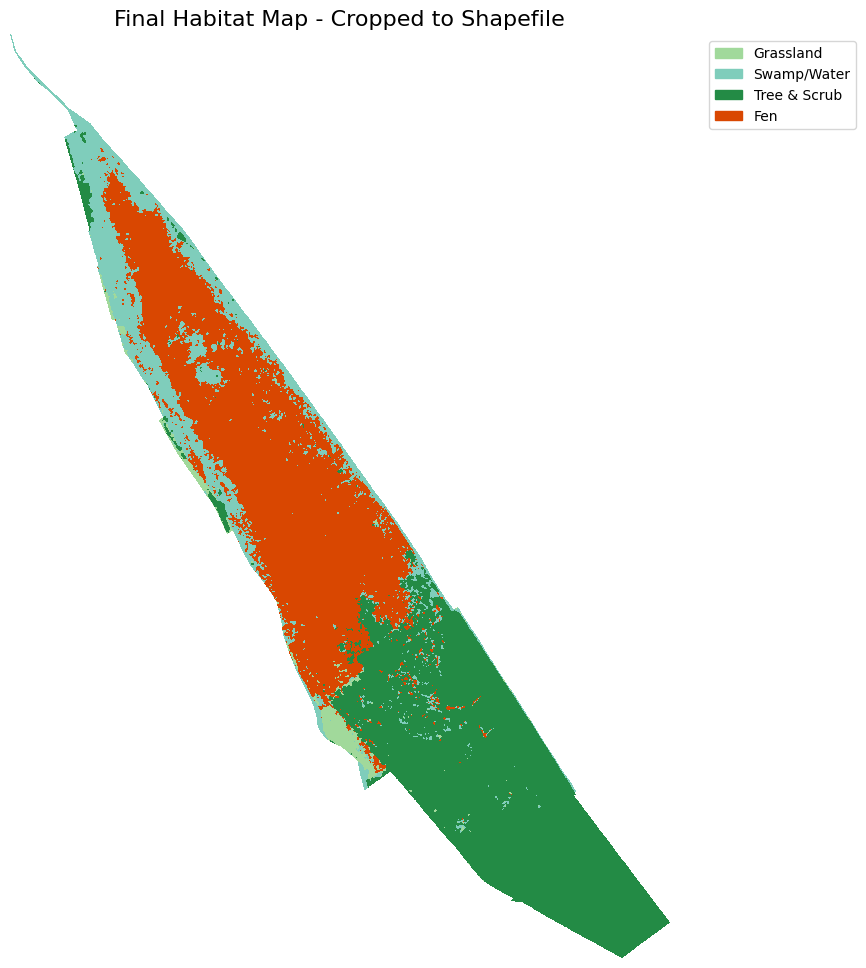

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

# 1. Load your shapefile and the TIF
shp_path = "/content/dataset/scraghbog/scraghBog_habiMap.shp" # Update this to your SHP path
map_path = "/content/drive/MyDrive/Habitat_Map_Final_5x5Filtered.tif"

gdf = gpd.read_file(shp_path)

with rasterio.open(map_path) as src:
    # 2. Use the shapefile geometry to "crop" the raster
    # This physically removes all pixels outside the shapefile boundary
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_image = out_image[0] # Get the first band
    extent = rasterio.plot.plotting_extent(out_image, out_transform)

# 3. Create an RGBA image for perfect transparency
h, w = out_image.shape
rgba = np.zeros((h, w, 4), dtype=np.uint8)

# 4. Professional Color Definitions
color_map = {
    1: [161, 217, 155], # Grassland
    2: [127, 205, 187], # Swamp/Water
    3: [35, 139, 69],   # Tree & Scrub
    4: [217, 71, 1]     # Fen
}

# 5. Fill only where the shapefile cutout has data
for val, rgb in color_map.items():
    match = (out_image == val)
    rgba[match, 0:3] = rgb
    rgba[match, 3] = 255 # Solid opacity for habitat

# 6. Plotting
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(rgba, extent=extent, interpolation='nearest')

# Legend
legend_dict = {'Grassland': '#A1D99B', 'Swamp/Water': '#7FCDBB',
               'Tree & Scrub': '#238B45', 'Fen': '#D94701'}
patches = [mpatches.Patch(color=c, label=l) for l, c in legend_dict.items()]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Final Habitat Map - Cropped to Shapefile", fontsize=16)
plt.axis('off') # Remove teal box entirely
plt.show()

In [31]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix

# 1. Paths to your data
map_path = "/content/drive/MyDrive/Habitat_Map_Final_5x5Filtered.tif"
shp_path = "/content/dataset/scraghbog/scraghBog_habiMap.shp"

# 2. Define your class mapping (Must match your training logic)
label_to_int = {'Grassland': 1, 'Swamp/water': 2, 'Tree & scrub': 3, 'fen': 4}

with rasterio.open(map_path) as src:
    # Read the predicted map
    predicted_img = src.read(1)
    transform = src.transform
    crs = src.crs
    shape = src.shape

    # 3. Rasterize the Shapefile to create a "Ground Truth" image
    gdf = gpd.read_file(shp_path).to_crs(crs)

    # Map text labels in SHP to the same integers as the TIF
    # (Update 'HCH_MAPPED' to whatever column holds your habitat names)
    fossitt_merger = {
        'GS4': 1, 'PF1': 4, 'PF3': 4, 'WD4': 3, 'WN6': 3,
        'WN7': 3, 'FS1': 2, 'FS2': 2, 'FW2/WL2': 2
    }
    gdf['label_int'] = gdf['HCH_MAPPED'].map(fossitt_merger)

    # Create the ground truth raster
    ground_truth = rasterize(
        [(geom, value) for geom, value in zip(gdf.geometry, gdf.label_int)],
        out_shape=shape, transform=transform, fill=0
    )

# 4. Filter out the background (NoData/0)
# We only compare pixels where both the map and the shapefile have data
mask = (ground_truth > 0) & (predicted_img > 0)
y_true = ground_truth[mask]
y_pred = predicted_img[mask]

# 5. Generate Accuracy Metrics
print("--- Overall Accuracy Metrics ---")
print(f"Overall Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Kappa Coefficient: {cohen_kappa_score(y_true, y_pred):.3f}")

print("\n--- Detailed Class-Wise Accuracy ---")
target_names = [name for name, i in sorted(label_to_int.items(), key=lambda x: x[1])]
print(classification_report(y_true, y_pred, target_names=target_names))

# 6. Optional: Create a Confusion Matrix DataFrame
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
print("\n--- Confusion Matrix (True Rows vs Predicted Columns) ---")
print(cm_df)

--- Overall Accuracy Metrics ---
Overall Accuracy: 88.20%
Kappa Coefficient: 0.813

--- Detailed Class-Wise Accuracy ---
              precision    recall  f1-score   support

   Grassland       0.79      0.52      0.62     32066
 Swamp/water       0.58      0.80      0.67    122135
Tree & scrub       0.98      0.92      0.95    465138
         fen       0.91      0.88      0.90    450967

    accuracy                           0.88   1070306
   macro avg       0.81      0.78      0.79   1070306
weighted avg       0.90      0.88      0.89   1070306


--- Confusion Matrix (True Rows vs Predicted Columns) ---
              Grassland  Swamp/water  Tree & scrub     fen
Grassland         16563         9706          3627    2170
Swamp/water         148        98309          2293   21385
Tree & scrub       2163        15104        430183   17688
fen                2068        47088          2874  398937


/tmp/ipython-input-3485013397.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_import_df, palette='viridis')


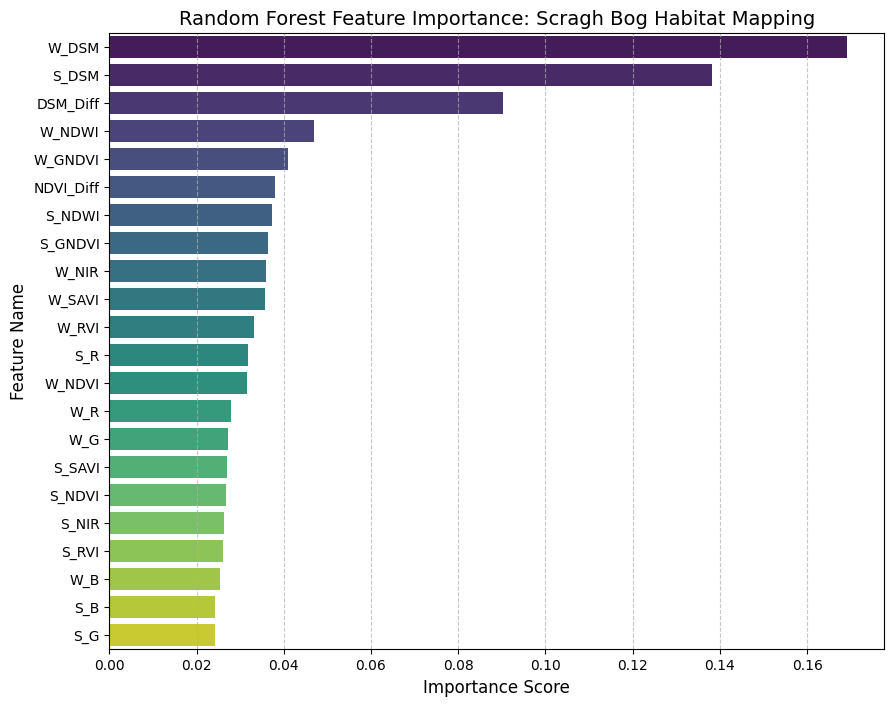

--- Top 5 Most Important Features ---
      Feature  Importance
9       W_DSM    0.169218
8       S_DSM    0.138102
21   DSM_Diff    0.090320
16     W_NDWI    0.046925
19    W_GNDVI    0.040968
20  NDVI_Diff    0.038035
12     S_NDWI    0.037212
15    S_GNDVI    0.036294
11      W_NIR    0.036009
18     W_SAVI    0.035625
17      W_RVI    0.033170
0         S_R    0.031730
7      W_NDVI    0.031499
3         W_R    0.027839
4         W_G    0.027155
14     S_SAVI    0.027004
6      S_NDVI    0.026667
10      S_NIR    0.026192
13      S_RVI    0.026123
5         W_B    0.025320


In [34]:
feature_names = [
    'S_R', 'S_G', 'S_B',
    'W_R', 'W_G', 'W_B',
    'S_NDVI', 'W_NDVI',
    'S_DSM', 'W_DSM',
    'S_NIR', 'W_NIR',
    'S_NDWI', 'S_RVI', 'S_SAVI', 'S_GNDVI',
    'W_NDWI', 'W_RVI', 'W_SAVI', 'W_GNDVI',
    'NDVI_Diff', 'DSM_Diff'
]
importances = rf.feature_importances_

# 2. Create a DataFrame for easy plotting
feat_import_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_import_df, palette='viridis')

plt.title('Random Forest Feature Importance: Scragh Bog Habitat Mapping', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 4. Print the top 20
print("--- Top 5 Most Important Features ---")
print(feat_import_df.head(20))